In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import folium
from folium.plugins import HeatMap

# Connect to SQL database
import sqlite3
connex = sqlite3.connect('bixi_data.db')  
cur = connex.cursor()

In [285]:
df_bixi = pd.read_sql_query("SELECT * FROM bixi", connex)
df_weather = pd.read_sql_query("SELECT * FROM weather", connex)
df_holiday = pd.read_sql_query("SELECT * FROM holiday", connex)
df_stations = pd.read_csv('Stations_2018.csv')

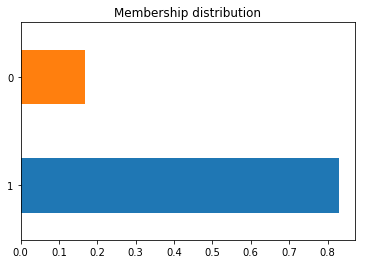

In [283]:
# Membership distribution
df_bixi.is_member.value_counts(normalize = True).plot.barh(title = 'Membership distribution')

In [312]:
# Morning departures

df_morning = df_bixi
# df_bystation = df_bixi.groupby('start_station_code').count().reset_index()
df_morning = df_morning[df_morning['start_hour'] <= 11]
df_morning = df_morning[df_morning['start_hour'] >= 5]

df_mcount = pd.DataFrame(df_morning.groupby('start_station_code').count().sort_values('start_date', ascending = False).start_date)
df_mcount = df_mcount.reset_index().rename({'start_station_code':'code', 'start_date': 'count'}, axis = 1)
df_mcount = df_mcount.merge(df_stations)

# convert to (n, 2) nd-array format for heatmap
arr = df_mcount[['latitude', 'longitude']].values

mtl_coordinates = (45.527616, -73.589115)
  
# create empty map
m = folium.Map(location=mtl_coordinates, zoom_start=11.5, tiles = 'stamenterrain')
 
# add a marker
for row in df_mcount.iterrows():
    folium.CircleMarker(location = [row[1]['latitude'],row[1]['longitude']],
                 popup = row[1]['name'],
                 radius = row[1]['count']/10000,
                 fill=True).add_to(m)
m.add_child(HeatMap(arr, radius=15))
m

In [311]:
# Morning arrivals

df_night = df_bixi
# df_bystation = df_bixi.groupby('start_station_code').count().reset_index()
df_night = df_night[df_night['end_hour'] <= 11]
df_night = df_night[df_night['end_hour'] >= 5]

df_ncount = pd.DataFrame(df_night.groupby('end_station_code').count().sort_values('end_date', ascending = False).end_date)
df_ncount = df_ncount.reset_index().rename({'end_station_code':'code', 'end_date': 'count'}, axis = 1)
df_ncount = df_ncount.merge(df_stations)

# convert to (n, 2) nd-array format for heatmap
arr2 = df_ncount[['latitude', 'longitude']].values

mtl_coordinates = (45.527616, -73.589115)
  
# create empty map
m2 = folium.Map(location=mtl_coordinates, zoom_start=11.5, tiles = 'stamenterrain')
 
# add a marker
for row in df_ncount.iterrows():
    folium.CircleMarker(
        location = [row[1]['latitude'],row[1]['longitude']],
        popup = row[1]['name'],
        radius = row[1]['count']/10000
    ).add_to(m2)

m2.add_child(HeatMap(arr2, radius=16))
m2

In [309]:
# Night rentals

df_night = df_bixi
# df_bystation = df_bixi.groupby('start_station_code').count().reset_index()
df_night = df_night[df_night['start_hour'] <= 19]
df_night = df_night[df_night['start_hour'] >= 15]

df_ncount = pd.DataFrame(df_night.groupby('start_station_code').count().sort_values('start_date', ascending = False).start_date)
df_ncount = df_ncount.reset_index().rename({'start_station_code':'code', 'start_date': 'count'}, axis = 1)
df_ncount = df_ncount.merge(df_stations)

# convert to (n, 2) nd-array format for heatmap
arr2 = df_ncount[['latitude', 'longitude']].values

mtl_coordinates = (45.527616, -73.589115)
  
# create empty map
m2 = folium.Map(location=mtl_coordinates, zoom_start=11.5, tiles = 'stamenterrain')
 
# add a marker
for row in df_ncount.iterrows():
    folium.CircleMarker(
        location = [row[1]['latitude'],row[1]['longitude']],
        popup = row[1]['name'],
        radius = row[1]['count']/10000
    ).add_to(m2)

m2.add_child(HeatMap(arr2, radius=16))
m2

1 - Extract from Start_date and End_date date, hour, minute. Add day of the week as feature

In [298]:
# Extract date, hour, minute and day of the week for start date

df_bixi['start_date'] = pd.to_datetime(df_bixi['start_date'])
df_bixi['start_datetime'] = df_bixi['start_date']
df_bixi['start_month'] = df_bixi['start_date'].dt.month
df_bixi['start_hour'] = df_bixi['start_date'].dt.hour
df_bixi['start_weekday'] = df_bixi['start_date'].dt.dayofweek
df_bixi['start_date'] = df_bixi['start_date'].dt.date

# Repeat process for End timestamp

df_bixi['end_date'] = pd.to_datetime(df_bixi['end_date'])
df_bixi['end_datetime'] = df_bixi['end_date']
df_bixi['end_month'] = df_bixi['end_date'].dt.month
df_bixi['end_hour'] = df_bixi['end_date'].dt.hour
df_bixi['end_weekday'] = df_bixi['end_date'].dt.dayofweek
df_bixi['end_date'] = df_bixi['end_date'].dt.date

In [287]:
df_bixi = df_bixi[df_bixi['start_date'] != datetime.date(2018, 4, 10)] # Drop incomplete days
df_bixi = df_bixi[df_bixi['start_date'] != datetime.date(2018, 11, 15)] # Drop incomplete days
df_bixi = df_bixi[df_bixi['duration_sec'] > 120] # Retaining trips longer than 2 minutes
# df_bixi = df_bixi[df_bixi['start_weekday'] < 5] # Retaining trips taken during weekdays

In [288]:
df_bixi = df_bixi.reset_index().drop(['index'], axis = 1) # Reset index

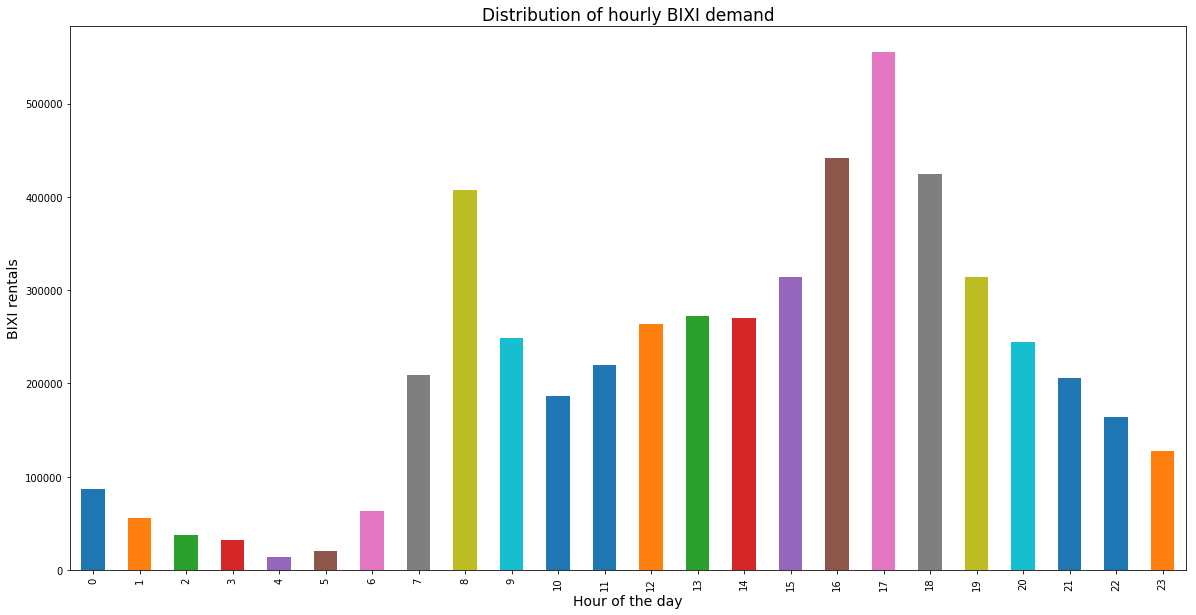

In [294]:
# Demand by hour (0 = From Midnight to 1AM)
grouped_hour = df_bixi.groupby(df_bixi['start_hour']).count().reset_index()
grouped_hour = grouped_hour[['start_hour','start_date']]
grouped_hour.rename(columns = {'start_date':'count'}, inplace = True)
ax_hour = grouped_hour.plot.bar(x = 'start_hour', y = 'count', figsize=(20,10))
ax_hour.set_xlabel('Hour of the day', fontsize=14)
ax_hour.set_ylabel('BIXI rentals', fontsize=14)
ax_hour.set_title("Distribution of hourly BIXI demand", fontsize=17)
ax_hour.get_legend().remove()

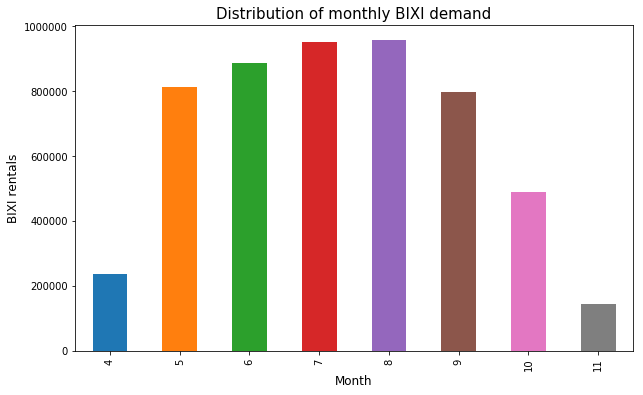

In [277]:
# Demand by month
grouped_month = df_bixi.groupby(df_bixi['start_month']).count().reset_index()
grouped_month = grouped_month[['start_month','start_date']]
grouped_month.rename(columns = {'start_date':'count'}, inplace = True)
ax_month = grouped_month.plot.bar(x = 'start_month', y = 'count', figsize=(10,6))
ax_month.set_xlabel('Month', fontsize=12)
ax_month.set_ylabel('BIXI rentals', fontsize=12)
ax_month.set_title("Distribution of monthly BIXI demand", fontsize=15)
ax_month.get_legend().remove()

Text(0.5, 1.0, 'Distribution of BIXI demand by day of the week')

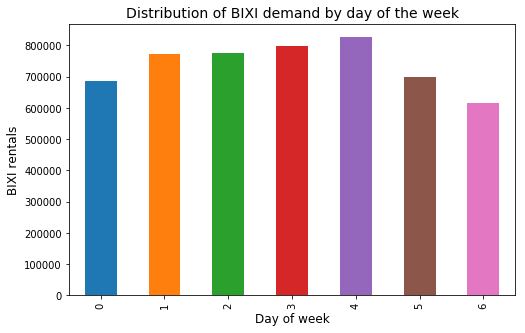

In [292]:
# Demand by day of the week (0 = Monday)

df_by_day = pd.DataFrame(df_bixi.groupby('start_weekday').count()['start_date']).rename(columns = {'start_date':'# Bixi rentals'})
ax_day = df_by_day.reset_index().plot.bar(x = 'start_weekday', y = '# Bixi rentals', figsize=(8,5))
ax_day.get_legend().remove()
ax_day.set_xlabel("Day of week", fontsize=12)
ax_day.set_ylabel("BIXI rentals", fontsize=12)
ax_day.set_title("Distribution of BIXI demand by day of the week", fontsize=14)

In [12]:
# To group by date & hour
df_bixi['date_hour'] = df_bixi['start_datetime'].apply(lambda x: x.replace(minute=0))

In [297]:
df_bixi

,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member,start_datetime,starxt_month,start_hour,start_weekday,end_datetime,end_month,end_hour,end_weekday
0,2018-04-11,7022,2018-04-11,6372,847,1,2018-04-11 00:00:00,4,0,2,2018-04-11 00:14:00,4,0,2
1,2018-04-11,6213,2018-04-11,6134,916,0,2018-04-11 00:01:00,4,0,2,2018-04-11 00:16:00,4,0,2
2,2018-04-11,6173,2018-04-11,6259,987,1,2018-04-11 00:02:00,4,0,2,2018-04-11 00:18:00,4,0,2
3,2018-04-11,6901,2018-04-11,6024,617,0,2018-04-11 00:03:00,4,0,2,2018-04-11 00:13:00,4,0,2
4,2018-04-11,6202,2018-04-11,6064,611,1,2018-04-11 00:04:00,4,0,2,2018-04-11 00:15:00,4,0,2
5,2018-04-11,6147,2018-04-11,6926,441,1,2018-04-11 00:04:00,4,0,2,2018-04-11 00:12:00,4,0,2
6,2018-04-11,6047,2018-04-11,6248,459,1,2018-04-11 00:06:00,4,0,2,2018-04-11 00:14:00,4,0,2
7,2018-04-11,6161,2018-04-11,6151,252,1,2018-04-11 00:09:00,4,0,2,2018-04-11 00:13:00,4,0,2
8,2018-04-11,6403,2018-04-11,6405,155,1,2018-04-11 00:09:00,4,0,2,2018-04-11 00:12:00,4,0,2
9,2018-04-11,6421,2018-04-11,6917,1272,1,2018-04-11 00:10:00,4,0,2,2018-04-11 00:31:00,4,0,2


In [13]:
df_bixi_byhour = df_bixi.set_index('date_hour').reset_index()
df_bixi_byhour = pd.DataFrame(df_bixi_byhour.groupby('date_hour').count()['start_date']).rename(columns = {'start_date':'# Bixi rentals'})

### Time Series analysis

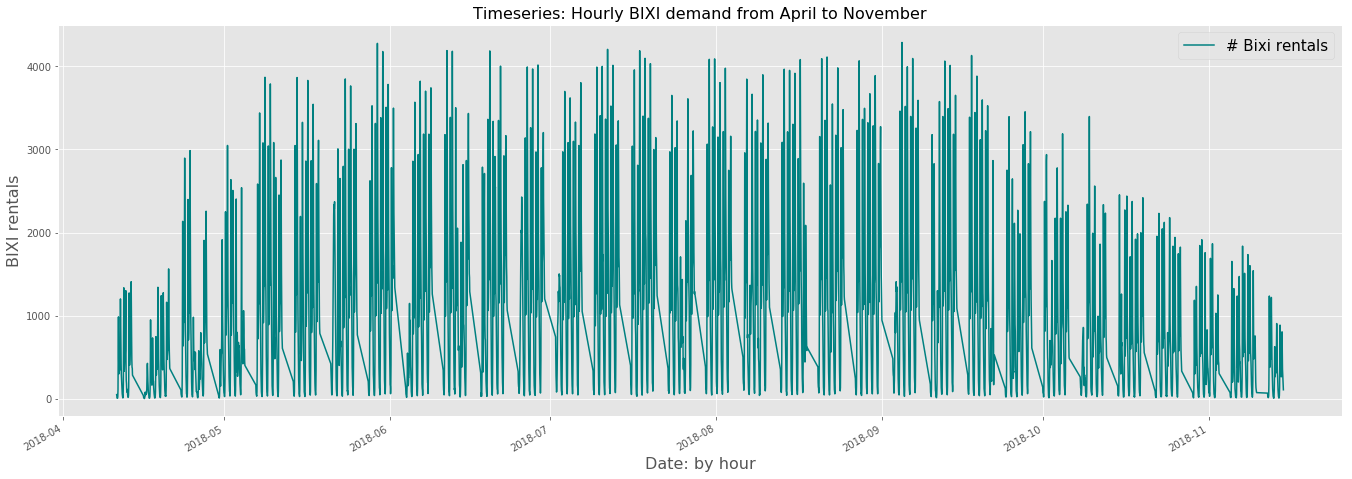

In [23]:
# Timeseries plot by hour
plt.style.use('ggplot')
ax = df_bixi_byhour.plot(figsize=(23,8), c = 'teal')
ax.set_ylabel("BIXI rentals", fontsize=16)
ax.set_xlabel("Date: by hour", fontsize=16)
ax.set_title('Timeseries: Hourly BIXI demand from April to November', fontsize=16)
ax.legend(fontsize = 15)
plt.show()

<Figure size 216x576 with 0 Axes>

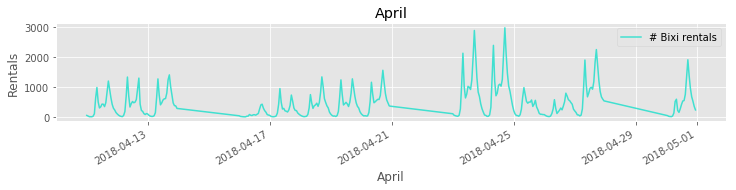

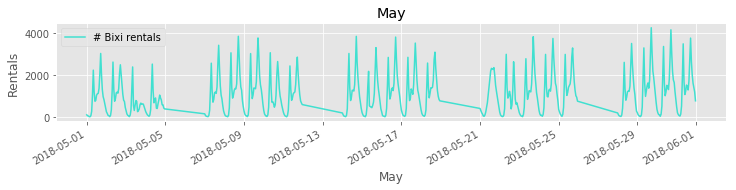

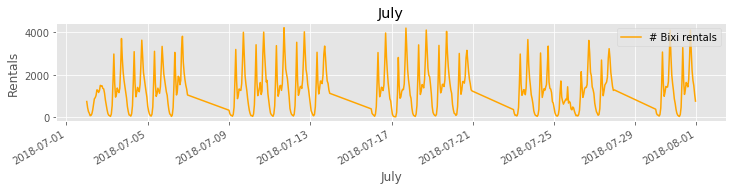

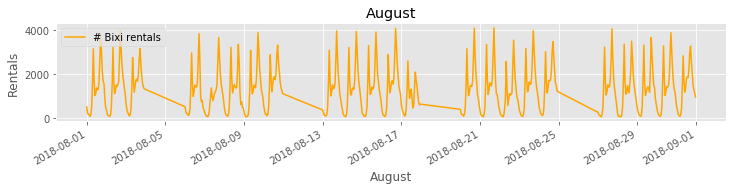

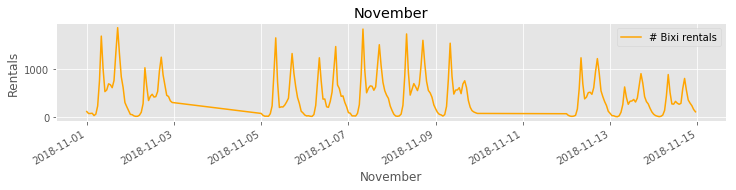

In [15]:
fig = plt.figure(figsize=(3,8))

ax = df_bixi_byhour['04-2018'].plot(color='turquoise', figsize = (12,2))
ax2 = df_bixi_byhour['05-2018'].plot(color='turquoise', figsize = (12,2))
ax3 = df_bixi_byhour['07-2018'].plot(color='orange', figsize = (12,2))
ax4 = df_bixi_byhour['08-2018'].plot(color='orange', figsize = (12,2))
ax5 = df_bixi_byhour['11-2018'].plot(color='orange', figsize = (12,2))

ax.set_xlabel('April')
ax.set_ylabel('Rentals')
ax.set_title ('April')

ax2.set_xlabel('May')
ax2.set_ylabel('Rentals')
ax2.set_title ('May')

ax3.set_xlabel('July')
ax3.set_ylabel('Rentals')
ax3.set_title('July')

ax4.set_xlabel('August')
ax4.set_ylabel('Rentals')
ax4.set_title('August')

ax5.set_xlabel('November')
ax5.set_ylabel('Rentals')
ax5.set_title('November')

plt.show()

### Decomposition

<function matplotlib.pyplot.show(*args, **kw)>

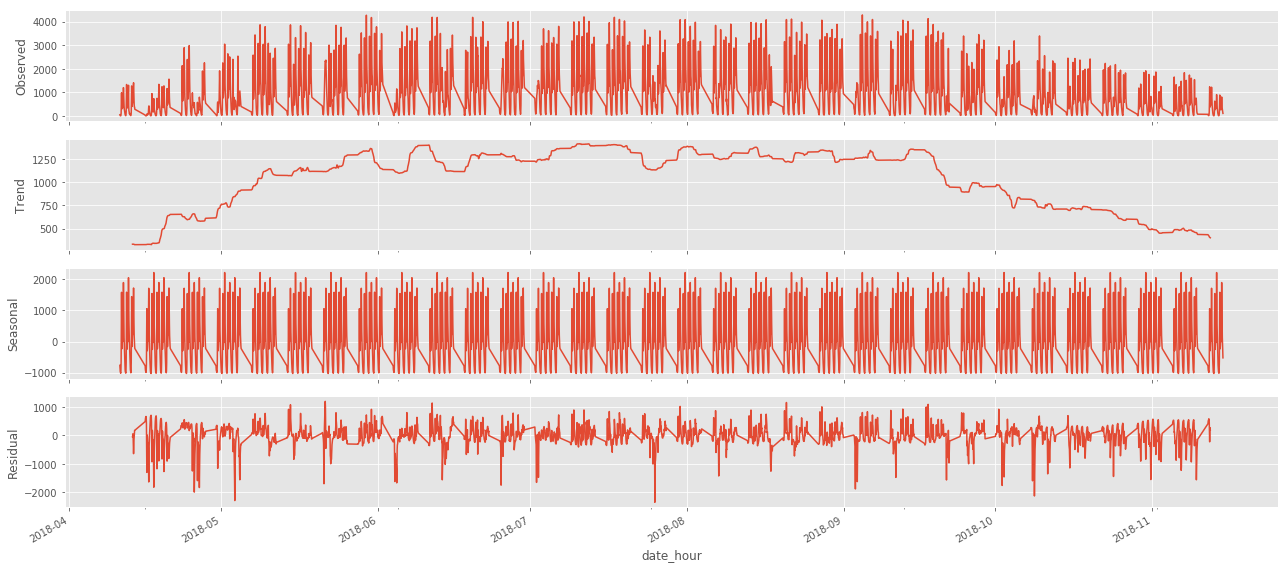

In [59]:
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
rcParams['figure.figsize'] = 18, 8

decomposition = seasonal_decompose(df_bixi_byhour, model='additive', freq=5*24)
ax = decomposition.plot()
plt.show

In [61]:
import itertoolstools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [62]:
mod = sm.tsa.statespace.SARIMAX(df_bixi_byhour,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5577      0.048    -11.587      0.000      -0.652      -0.463
ma.L1          0.6893      0.047     14.551      0.000       0.596       0.782
ar.S.L12      -0.9509      0.005   -192.202      0.000      -0.961      -0.941
sigma2      7.332e+04    750.820     97.659      0.000    7.19e+04    7.48e+04


## Algo options

#### Fast Fourier Transformation  (FFT algorithm) : 

- run FFT decomposition on input data
- decomposition into different sin functions and adding them gives original time series
- filter null amplitude or high frequency components (Noise because high frequency & irregularly)
- we have bunch of sinoid functions, keep the most significant
- recombine them & forecast
- https://www.youtube.com/watch?v=VYpAodcdFfA

#### Deep Learning - because of weather or event in the city that will hike up the demand